# Labs 3

### Dostosuj aplikację graficzną tak, aby można było zadawać proste wielokąty przy użyciu myszki, z dodatkowym zapisem i odczytem podanych wielokątów. Wielokąty powinny być zadawane w kierunku przeciwnym do ruchu wskazówek zegara.

Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
%matplotlib notebook
import json as js
from math import inf

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

Interfejsy

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

Funkcje pomocnicze

In [3]:
def det(a, b, c, epsilon=10 ** (-12)):
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c
    first = (a_x - c_x) * (b_y - c_y)
    second = (a_y - c_y) * (b_x - c_x)
    determinant = first - second
    return determinant

def classify(a, b, c, starting, closing, connective, separative, correct, epsilon=10 ** (-12)):
    # starting or separative or correct
    if a[1] < b[1] and c[1] < b[1]:
        # starting
        if det(a, b, c) > epsilon:
            starting.append(b)
        # separative
        elif det(a, b, c) < -epsilon:
            separative.append(b)

    # closing or connective or correct
    elif a[1] > b[1] and c[1] > b[1]:
        # closing
        if det(a, b, c) > epsilon:
            closing.append(b)
        # connective
        elif det(a, b, c) < -epsilon:
            connective.append(b)

    # correct
    else:
        correct.append(b)
        
def convert_to_lines(points):
    lines = []
    for p in range(len(points)-1):
        lines.append((points[p], points[p+1]))
    lines.append((points[-1], points[0]))
    return lines

def connective_or_separative(a, b, c, epsilon = 10 ** (-12)):
    determinant = det(a, b, c)
    if a[1] > b[1] and c[1] > b[1] and determinant < -epsilon:
        return True
    elif a[1] < b[1] and c[1] < b[1] and determinant < -epsilon:
        return True
    return False

---
### Zaimplementuj procedurę sprawdzającą, czy podany wielokąt jest y-monotoniczny. W sprawozdaniu opisz krótko tę metodę sprawdzania.

In [4]:
def y_monotonic(points):
    for i in range(0, len(points)-1):
        if connective_or_separative(points[i-1], points[i], points[i+1]):
            return False
    
    if connective_or_separative(points[-2], points[-1], points[0]):
        return False
    return True

---
### Zaimplementuj algorytm, który dla zadanego wielokąta będzie wyszukiwał wierzchołki początkowe, końcowe, łączące, dzielące i prawidłowe. Wierzchołki mają zostać odpowiednio pokolorowane zgodnie z klasyfikacją.

Legenda:
 - green (zielony) - starting (wierzchołek początkowy),
 - red (czerwony) - closing (wierzchołek końcowy),
 - dark blue (ciemnoniebieski) - connective (wierzchołek łączący),
 - light blue (jasnoniebieski) - separative (wierzchołek dzielący),
 - saddlebrown (brązowy) - correct (wierzchołek prawidłowy). 

In [5]:
def classify_points(points):
    starting = []
    closing = []
    connective = []
    separative = []
    correct = []
    # all points excep first and last
    for i in range(0, len(points)-1):
        classify(points[i-1], points[i], points[i+1], starting, closing, connective, separative, correct)
    
    # last point
    classify(points[-2], points[-1], points[0], starting, closing, connective, separative, correct)
    
    return starting, closing, connective, separative, correct

In [6]:
def draw_classification(points, starting, closing, connective, separative, correct):
    plot = Plot(points = [PointsCollection(starting, color = "green"),
                          PointsCollection(closing, color = "red"),
                          PointsCollection(connective, color = "darkblue"),
                          PointsCollection(separative, color = "lightblue"),
                          PointsCollection(correct, color = "saddlebrown")],
             lines=[LinesCollection(convert_to_lines(points), color = "black")])
    
    plot.draw()

---
### Zaimplementuj procedurę triangulacji wielokąta monotonicznego (zgodnie z algorytmem opisanym na wykładzie). Program powinien pokazywać kolejne kroki algorytmu (tzn. kolejne tworzone trójkąty).

Funkcje pomocniczne

In [7]:
def find_chains(points):
    right_chain = set()
    left_chain = set()
    starting = points.index(max(points, key=lambda x: x[1]))
    ending = points.index(min(points, key=lambda x: x[1]))
    i = ending
    while i != starting:
        right_chain.add(points[i])
        i = (i + 1) % len(points)
    while i != ending:
        left_chain.add(points[i])
        i = (i + 1) % len(points)
    return left_chain, right_chain


def check_same_chains(left_chain, right_chain, point1, point2):
    if (point1 in left_chain and point2 in left_chain) or (point1 in right_chain and point2 in right_chain):
        return True
    return False

def triangle_in_polygon(chain, a, b, c, epsilon=10 ** (-12)):
    if b in chain:
        return det(a, b, c) > epsilon
    else:
        return det(a, b, c) < -epsilon


def check_neighbours(points, a, b):
    a_index = points.index(a)
    b_index = points.index(b)
    if abs(a_index - b_index) == 1:
        return True
    elif abs(a_index - b_index) == len(points) - 1:
        return True
    return False

In [8]:
def triangulation(points):
    if not y_monotonic(points):
        print("Polygon is not y-monotonic.")
        return None, None
    print("Polygon is y-monotonic.")
    lines = convert_to_lines(points)
    scenes = [Scene(points=[PointsCollection(points, color='green')],
                    lines=[LinesCollection(lines, color='black')])]

    points_copy = points[:]
    left_chain, right_chain = find_chains(points)
    points.sort(key=lambda x: x[1], reverse=True)

    stack = [points[0], points[1]]
    diagonals = []
    for i in range(2, len(points)):
        if not check_same_chains(left_chain, right_chain, stack[-1], points[i]):
            while len(stack) > 0:
                p = stack.pop()
                if not check_neighbours(points_copy, p, points[i]):
                    diagonals.append((points[i], p))
                curr_diagonals = diagonals[:]
                curr_stack = stack[:]
                scenes.append(Scene(points=[PointsCollection(points, color="green"),
                                            PointsCollection(curr_stack, color="red")],
                                    lines=[LinesCollection(lines, color="black"),
                                           LinesCollection(curr_diagonals, color="blue")]))
            stack.append(points[i - 1])
            stack.append(points[i])
        else:
            p = stack.pop()
            while len(stack) > 0 and triangle_in_polygon(left_chain, stack[-1], p, points[i]):
                if not check_neighbours(points_copy, p, points[i]) and \
                        (points[i], p) not in diagonals:
                    diagonals.append((points[i], p))
                if not check_neighbours(points_copy, stack[-1], points[i]) and \
                        (points[i], stack[-1]) not in diagonals:
                    diagonals.append((points[i], stack[-1]))
                p = stack.pop()
                curr_diagonals = diagonals[:]
                curr_stack = stack[:]
                scenes.append(Scene(points=[PointsCollection(points, color="green"),
                                            PointsCollection(curr_stack, color="red")],
                                    lines=[LinesCollection(lines, color="black"),
                                           LinesCollection(curr_diagonals, color="blue")]))
            stack.append(p)
            stack.append(points[i])
    return diagonals, scenes

---
### Przetestuj programy na różnych zestawach danych. W sprawozdaniu napisz, jakiego typu zestawy testowano. Uzasadnij wybór danych testujących.

Funkcja zwracająca punkty z rysunku

In [9]:
def points_from_plot(plot):
    points = []
    lines = plot.get_added_figure()[0].lines
    for l in lines:
        points.append(l[0])
    points.append(lines[len(lines) - 1][1])
    return points

**Zbiory danych**

In [10]:
points1 = [(3,-2), (-2,3), (6,6), (1,5), (-3,7), (-6,1), (-2, -11)]

points2 = [(3,-2), (14,3), (9,7), (1,12), (-4,6), (-3, 4), (-2, -11)]

points3 = [(-8, -2), (8, -4), (0, 1), (-4, -7), (-4, -8), (-9, -1), (0, 7), (6, 5), (9, 7), (-1, -9)]

points4 = [(-4, -16), (7, 3), (9, 8), (2, 11), (-8, 3), (-14, -1), (-7, -4), (-5, -10)]

points5 = [(7, -100), (43, -50), (123, 5), (50, 50), (0, 100)]

**1) Test czy wielokąt jest y-monotoniczny**

False


<IPython.core.display.Javascript object>


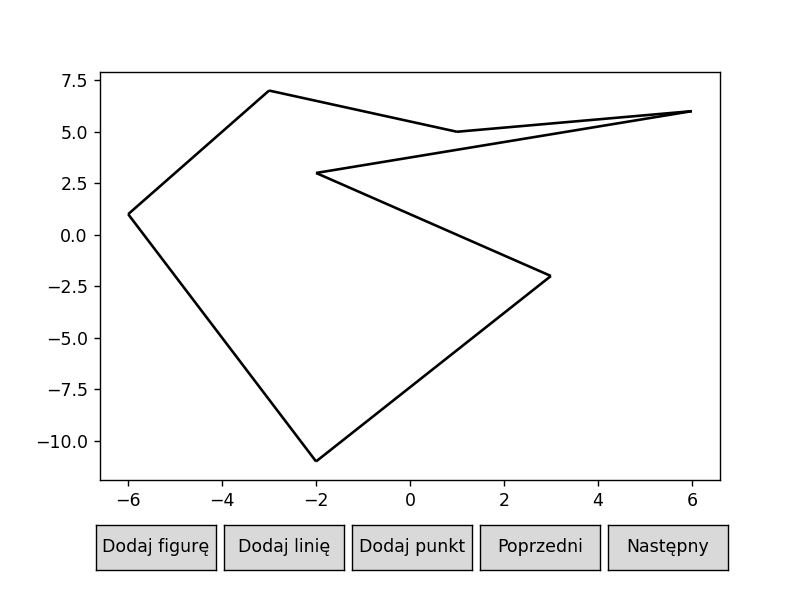

In [29]:
print(y_monotonic(points1))
plot1 = Plot(lines=[LinesCollection(convert_to_lines(points1), color = "black")])
    
plot1.draw()

True


<IPython.core.display.Javascript object>


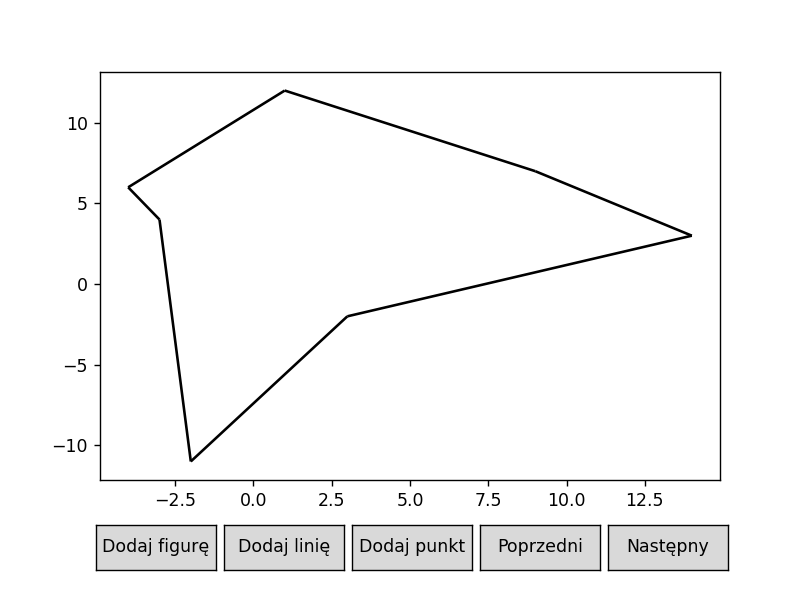

In [31]:
print(y_monotonic(points2))
plot2 = Plot(lines=[LinesCollection(convert_to_lines(points2), color = "black")])
    
plot2.draw()

False


<IPython.core.display.Javascript object>


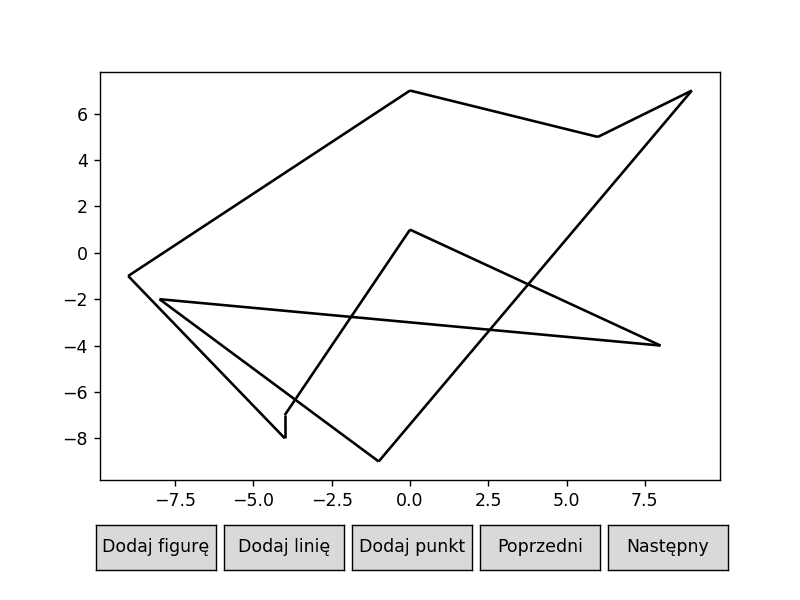

In [32]:
print(y_monotonic(points3))
plot3 = Plot(lines=[LinesCollection(convert_to_lines(points3), color = "black")])
    
plot3.draw()

True


<IPython.core.display.Javascript object>


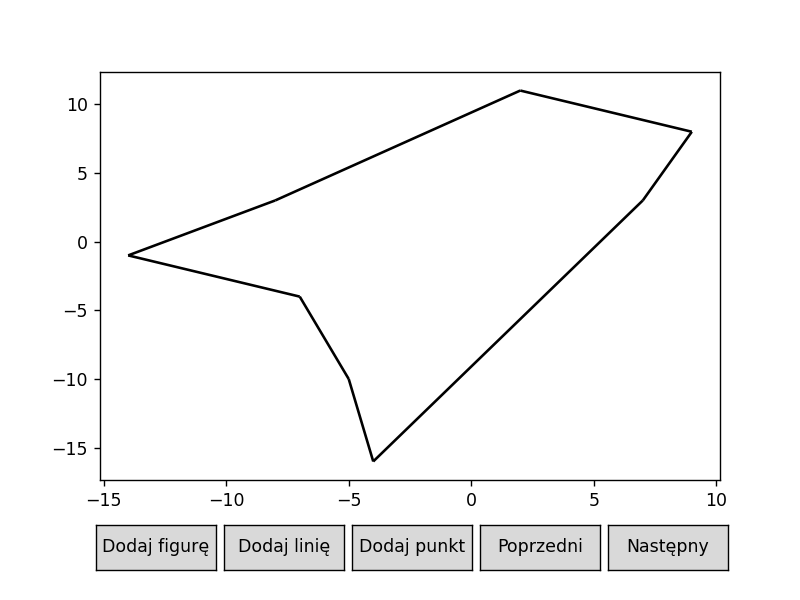

In [33]:
print(y_monotonic(points4))
plot4 = Plot(lines=[LinesCollection(convert_to_lines(points4), color = "black")])
    
plot4.draw()

True


<IPython.core.display.Javascript object>


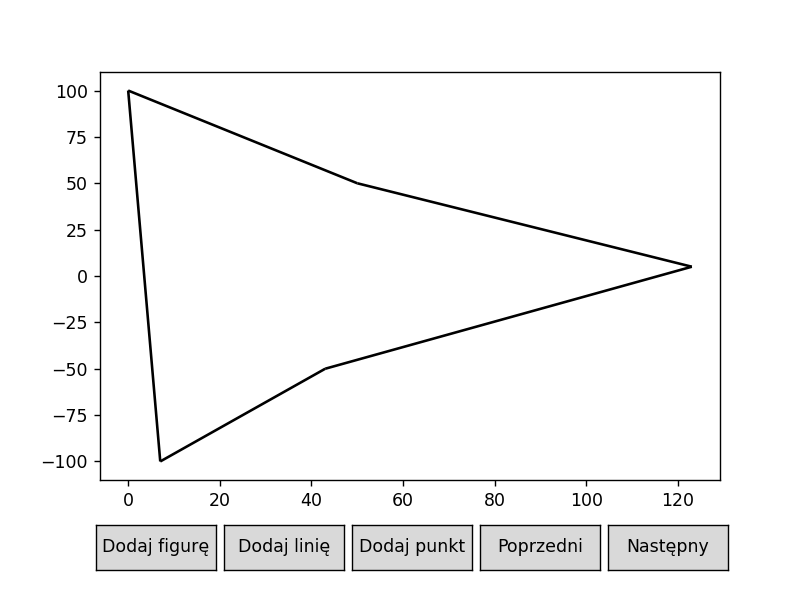

In [34]:
print(y_monotonic(points5))
plot5 = Plot(lines=[LinesCollection(convert_to_lines(points5), color = "black")])
    
plot5.draw()

**2) Test klasyfikacji punktów**

<IPython.core.display.Javascript object>


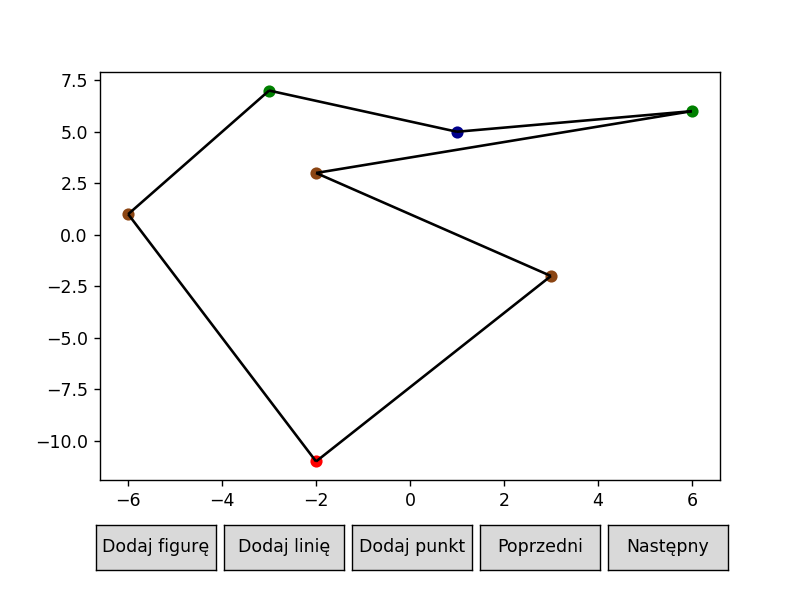

In [35]:
starting, closing, connective, separative, correct = classify_points(points1)
draw_classification(points1, starting, closing, connective, separative, correct)

<IPython.core.display.Javascript object>


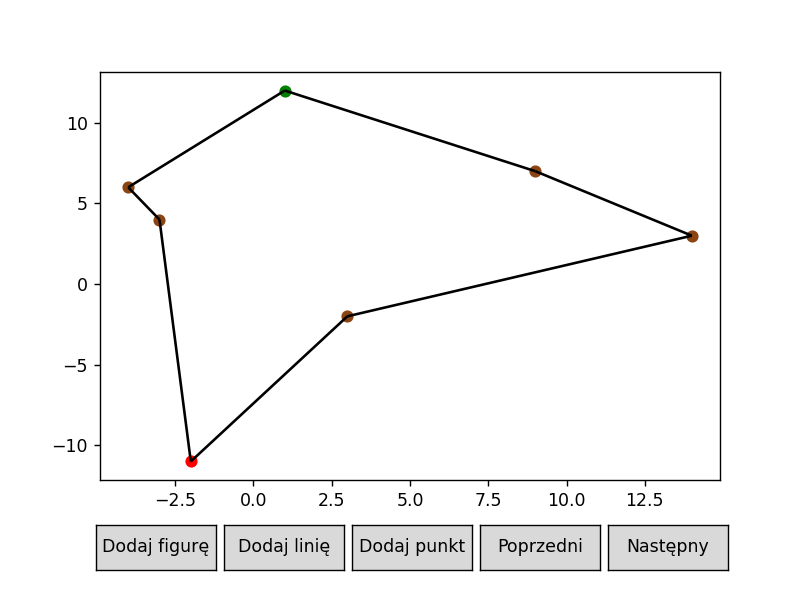

In [36]:
starting, closing, connective, separative, correct = classify_points(points2)
draw_classification(points2, starting, closing, connective, separative, correct)

<IPython.core.display.Javascript object>


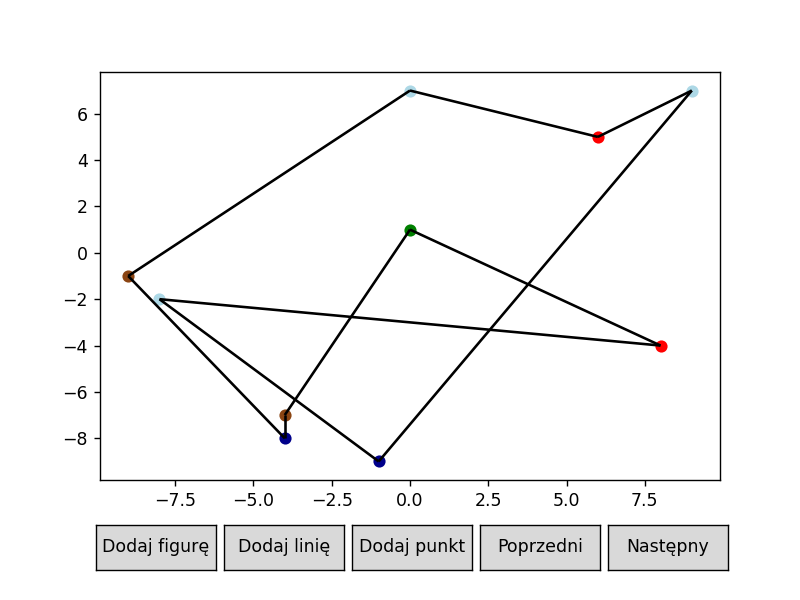

In [37]:
starting, closing, connective, separative, correct = classify_points(points3)
draw_classification(points3, starting, closing, connective, separative, correct)

<IPython.core.display.Javascript object>


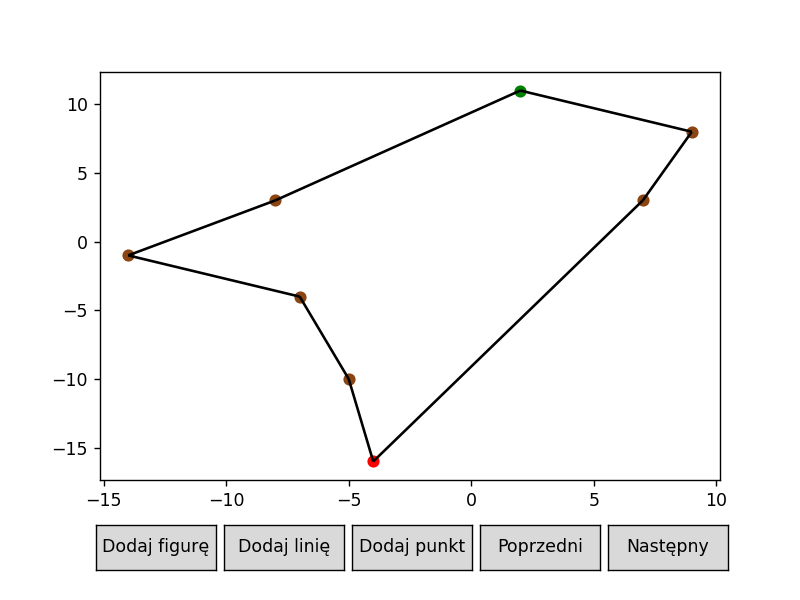

In [38]:
starting, closing, connective, separative, correct = classify_points(points4)
draw_classification(points4, starting, closing, connective, separative, correct)

<IPython.core.display.Javascript object>


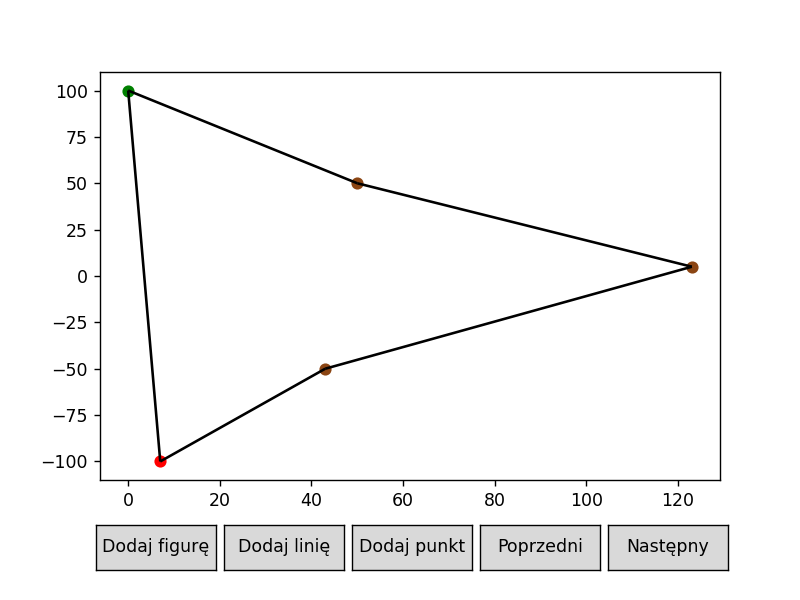

In [39]:
starting, closing, connective, separative, correct = classify_points(points5)
draw_classification(points5, starting, closing, connective, separative, correct)

**3) Test triangulacji**

Polygon is y-monotonic.
[((-4, 6), (9, 7)), ((-3, 4), (9, 7)), ((14, 3), (-3, 4)), ((3, -2), (-3, 4))]


<IPython.core.display.Javascript object>


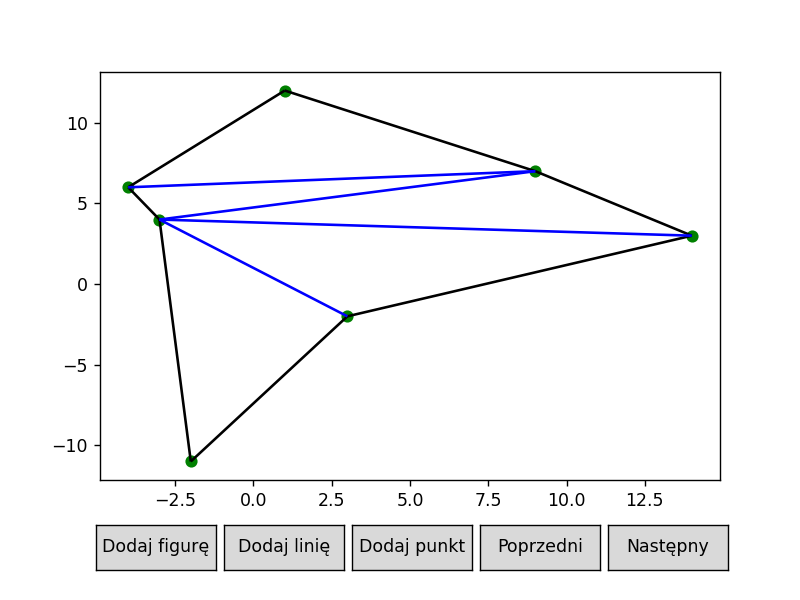

In [40]:
diagonals6, scenes6 = triangulation(points2)
plot6 = Plot(scenes6)
print(diagonals6)
plot6.draw()

Polygon is y-monotonic.
[((7, 3), (2, 11)), ((-8, 3), (7, 3)), ((-14, -1), (7, 3)), ((-7, -4), (7, 3)), ((-5, -10), (7, 3))]


<IPython.core.display.Javascript object>


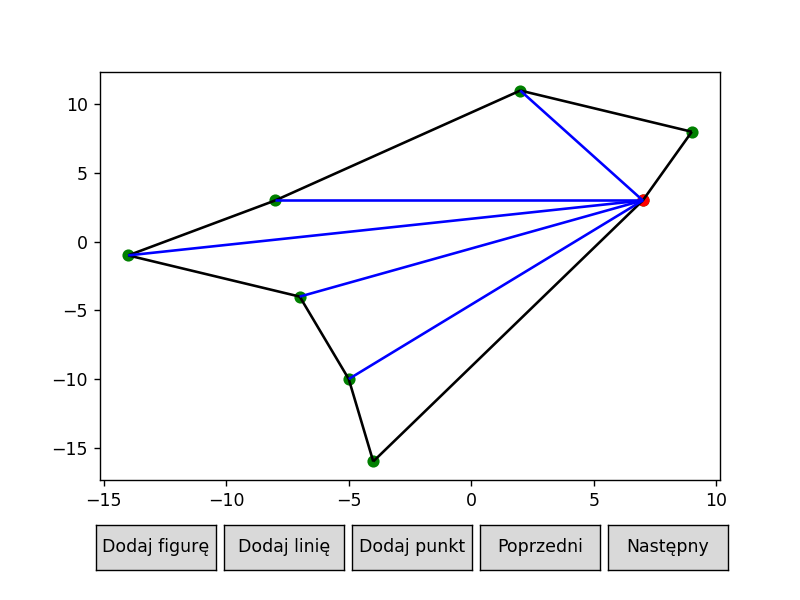

In [41]:
diagonals7, scenes7 = triangulation(points4)
plot7 = Plot(scenes7)
print(diagonals7)
plot7.draw()

Polygon is y-monotonic.
[((43, -50), (50, 50)), ((43, -50), (0, 100))]


<IPython.core.display.Javascript object>


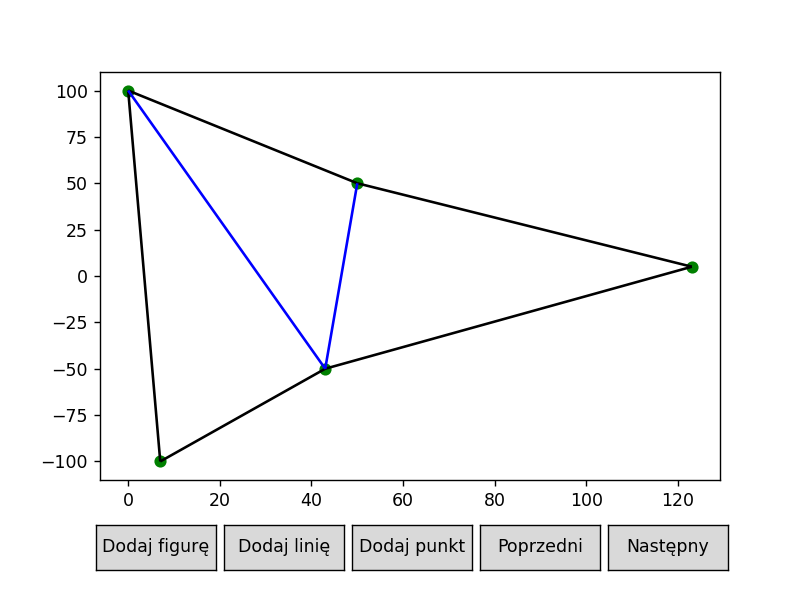

In [42]:
diagonals8, scenes8 = triangulation(points5)
plot8 = Plot(scenes8)
print(diagonals8)
plot8.draw()

Polygon is y-monotonic.
[((7, 11), (9, 13)), ((4, 4), (4, 8)), ((4, 4), (7, 11)), ((4, 4), (9, 13)), ((9, 0), (4, 4))]


<IPython.core.display.Javascript object>


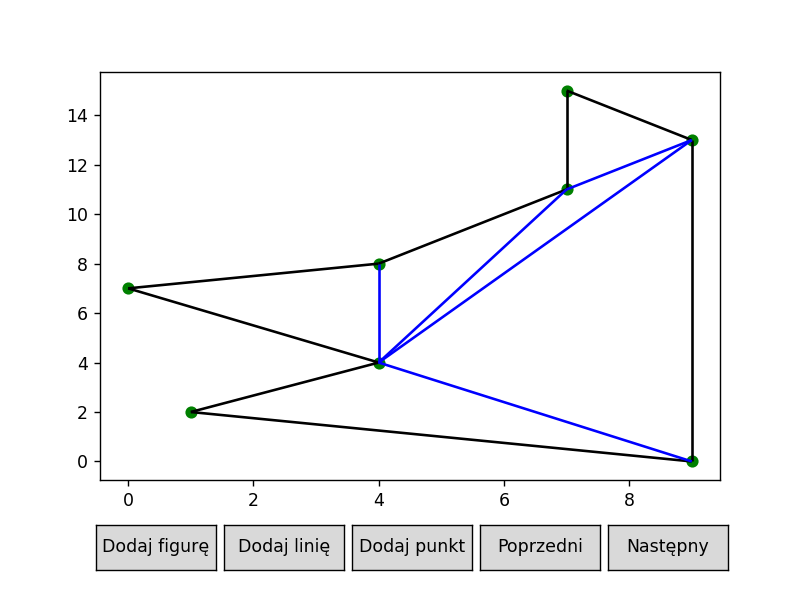

In [43]:
points6 = [(9, 0), (9, 13), (7, 15), (7, 11), (4, 8), (0, 7), (4, 4), (1, 2)]
diagonals9, scenes9 = triangulation(points6)
plot9 = Plot(scenes9)
print(diagonals9)
plot9.draw()

Polygon is y-monotonic.
[((3, 6), (-3, 7)), ((5, 2), (-3, 7)), ((-6, 1), (5, 2)), ((-2, -3), (-6, 1)), ((-3, -6), (-2, -3))]


<IPython.core.display.Javascript object>


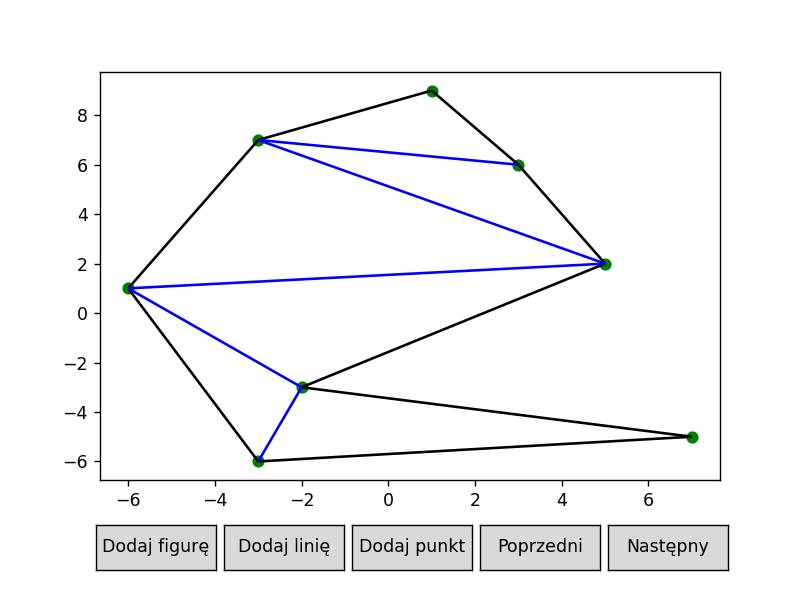

In [44]:
points7 = [(-2, -3), (5, 2), (3, 6), (1, 9), (-3, 7), (-6, 1), (-3, -6), (7, -5)]
diagonals10, scenes10 = triangulation(points7)
plot10 = Plot(scenes10)
print(diagonals10)
plot10.draw()

<IPython.core.display.Javascript object>


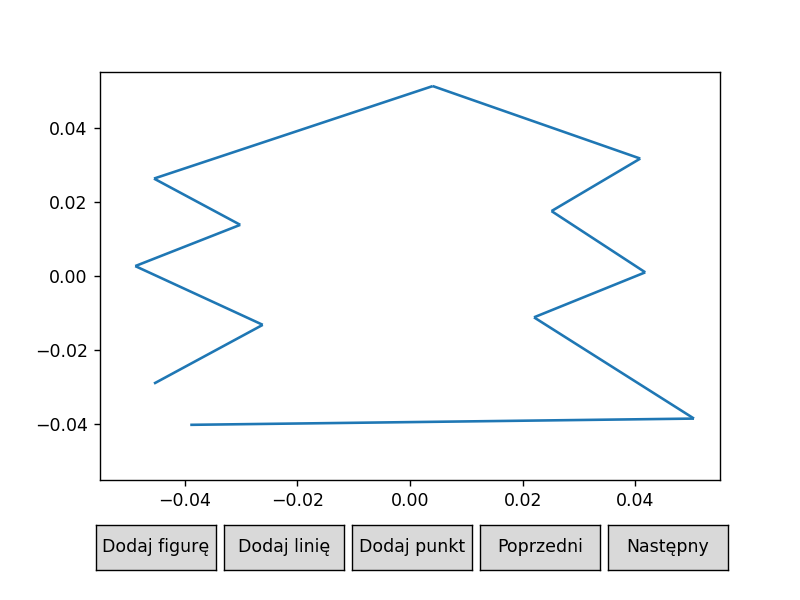

In [11]:
plot11 = Plot()
plot11.draw()

Polygon is y-monotonic.
[((-0.04541935213150518, 0.026264296699972725), (0.040850809158817405, 0.03165645356271782)), ((0.02510484141688192, 0.01750204179801193), (-0.04541935213150518, 0.026264296699972725)), ((-0.030116932776666466, 0.013794933954874675), (0.02510484141688192, 0.01750204179801193)), ((-0.048745965034730984, 0.002673610425462908), (0.02510484141688192, 0.01750204179801193)), ((0.04173790593301095, 0.0009885614058550707), (-0.048745965034730984, 0.002673610425462908)), ((0.022000002707204508, -0.011143791535321412), (-0.048745965034730984, 0.002673610425462908)), ((-0.0261249972927955, -0.013165850358850817), (0.022000002707204508, -0.011143791535321412)), ((-0.04541935213150518, -0.02900531114316455), (0.022000002707204508, -0.011143791535321412)), ((0.05038709948139805, -0.03844158565296848), (-0.04541935213150518, -0.02900531114316455))]


<IPython.core.display.Javascript object>


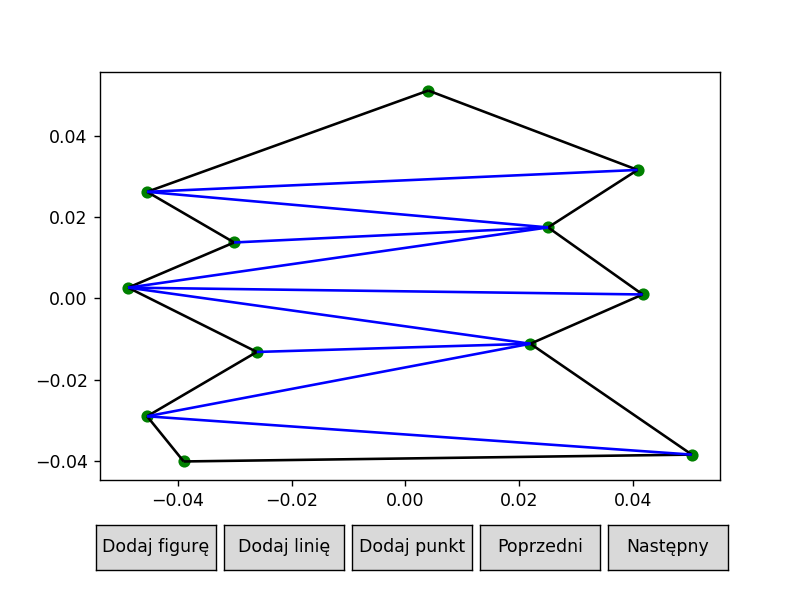

In [12]:
points8 = points_from_plot(plot11)
diagonals11, scenes11 = triangulation(points8)
plot11 = Plot(scenes11)
print(diagonals11)
plot11.draw()

<IPython.core.display.Javascript object>


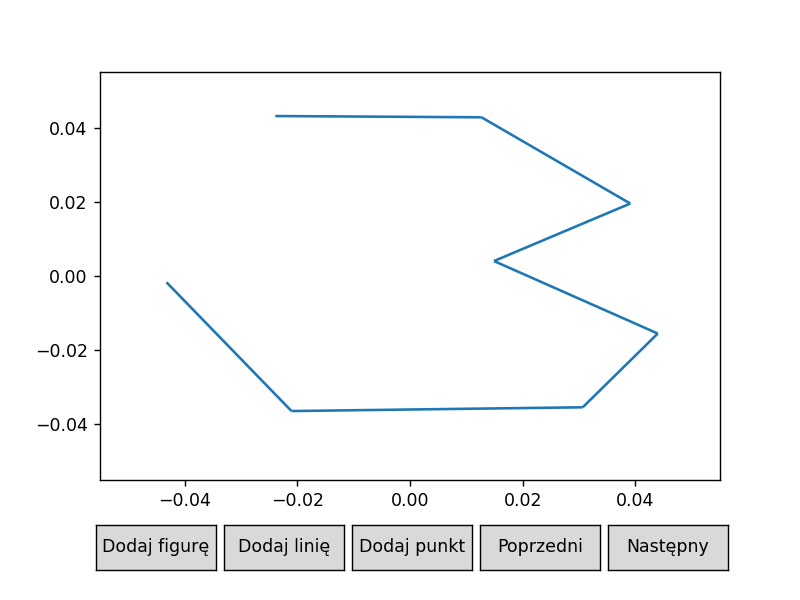

In [13]:
plot12 = Plot()
plot12.draw()

Polygon is y-monotonic.
[((0.03907661561043031, 0.019535336681440765), (-0.023907255357311627, 0.043126022955950596)), ((0.014903228513656122, 0.004032885701048608), (-0.023907255357311627, 0.043126022955950596)), ((-0.043201610196021305, -0.001696280965618066), (0.014903228513656122, 0.004032885701048608)), ((0.04395564786849483, -0.015513682926402372), (-0.043201610196021305, -0.001696280965618066)), ((0.030649196255591607, -0.035397261357774934), (-0.043201610196021305, -0.001696280965618066))]


<IPython.core.display.Javascript object>


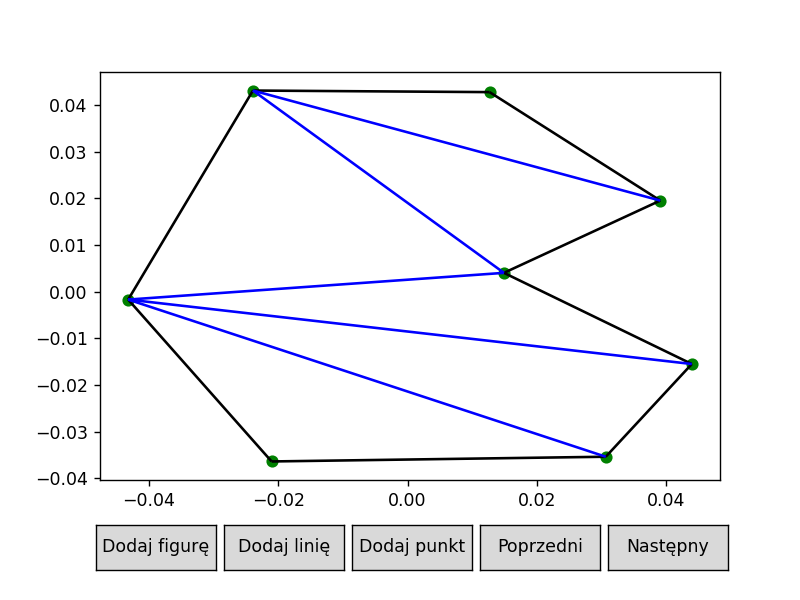

In [14]:
points9 = points_from_plot(plot12)
diagonals12, scenes12 = triangulation(points9)
plot12 = Plot(scenes12)
print(diagonals12)
plot12.draw()

<IPython.core.display.Javascript object>


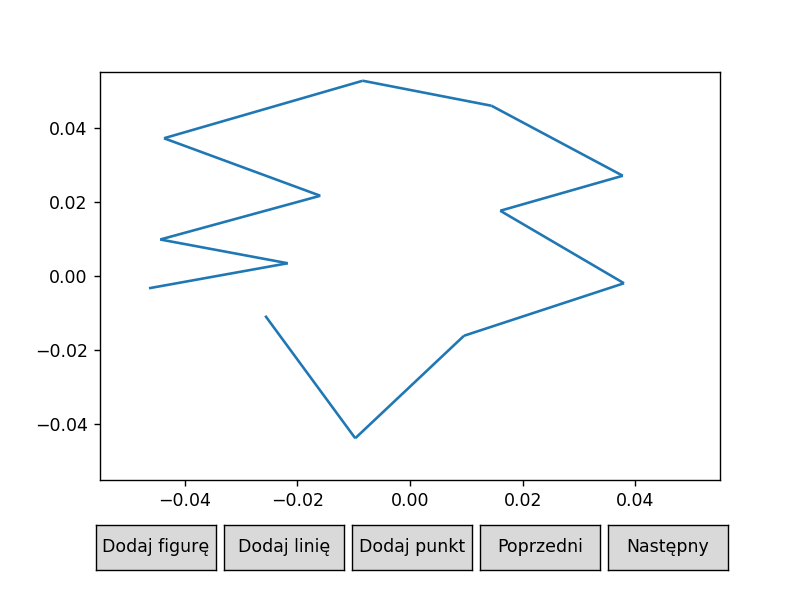

In [15]:
plot13 = Plot()
plot13.draw()

Polygon is y-monotonic.
[((-0.04364515858311808, 0.03713847833521228), (0.014459680126559349, 0.04590073323717307)), ((0.03774597044913999, 0.027028184217565213), (-0.04364515858311808, 0.03713847833521228)), ((-0.015923384389569688, 0.021636027354820106), (0.03774597044913999, 0.027028184217565213)), ((0.01601209948139805, 0.017591909707761283), (-0.015923384389569688, 0.021636027354820106)), ((-0.04431048116376324, 0.009840684217565204), (0.01601209948139805, 0.017591909707761283)), ((-0.021689513421827754, 0.0034374979430553954), (0.01601209948139805, 0.017591909707761283)), ((0.03796774464268837, -0.0019546589196896974), (-0.021689513421827754, 0.0034374979430553954)), ((-0.046306448905698724, -0.003302698135375981), (0.03796774464268837, -0.0019546589196896974)), ((-0.02568144890569872, -0.010716913821650492), (0.03796774464268837, -0.0019546589196896974)), ((0.00958064786849483, -0.016109070684395585), (-0.02568144890569872, -0.010716913821650492))]


<IPython.core.display.Javascript object>


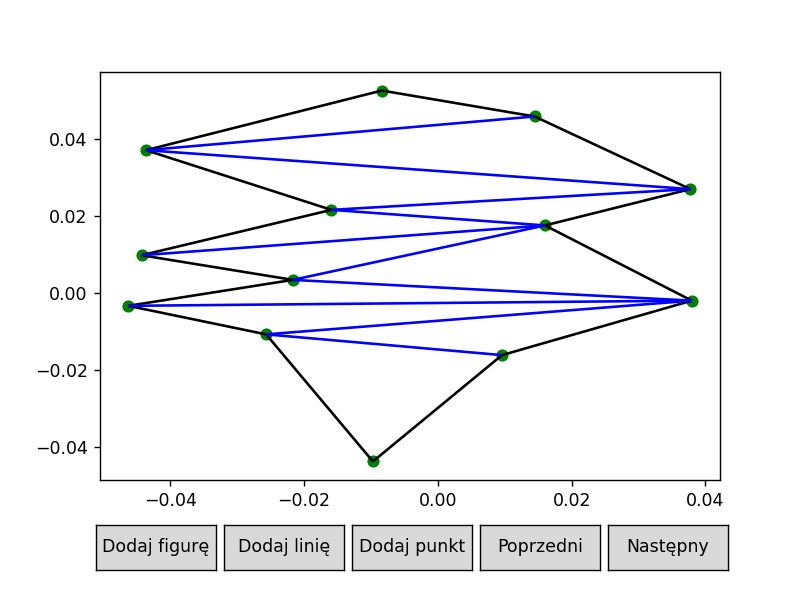

In [16]:
points10 = points_from_plot(plot13)
diagonals13, scenes13 = triangulation(points10)
plot13 = Plot(scenes13)
print(diagonals13)
plot13.draw()

<IPython.core.display.Javascript object>


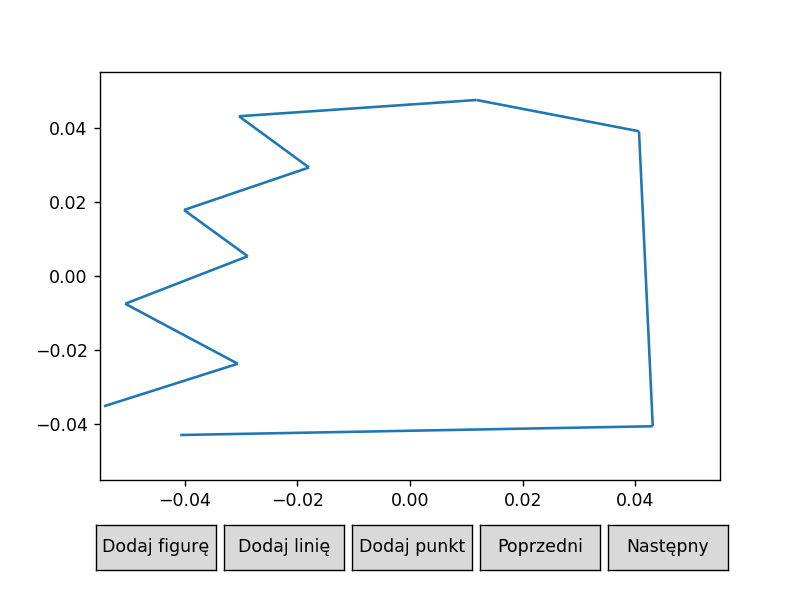

In [17]:
plot14 = Plot()
plot14.draw()

Polygon is y-monotonic.
[((0.040629034965269026, 0.03902573529411767), (-0.030338706970214853, 0.043069852941176476)), ((-0.017919352131505174, 0.02925245098039217), (0.040629034965269026, 0.03902573529411767)), ((-0.040096771486343885, 0.017794117647058835), (0.040629034965269026, 0.03902573529411767)), ((-0.02878628761537614, 0.005324754901960785), (0.040629034965269026, 0.03902573529411767)), ((-0.05052015858311808, -0.007481617647058833), (0.040629034965269026, 0.03902573529411767)), ((-0.03056048116376324, -0.023658088235294125), (0.040629034965269026, 0.03902573529411767)), ((0.043068551094301286, -0.040508578431372566), (-0.05429031987344066, -0.035116421568627466)), ((0.043068551094301286, -0.040508578431372566), (-0.03056048116376324, -0.023658088235294125))]


<IPython.core.display.Javascript object>


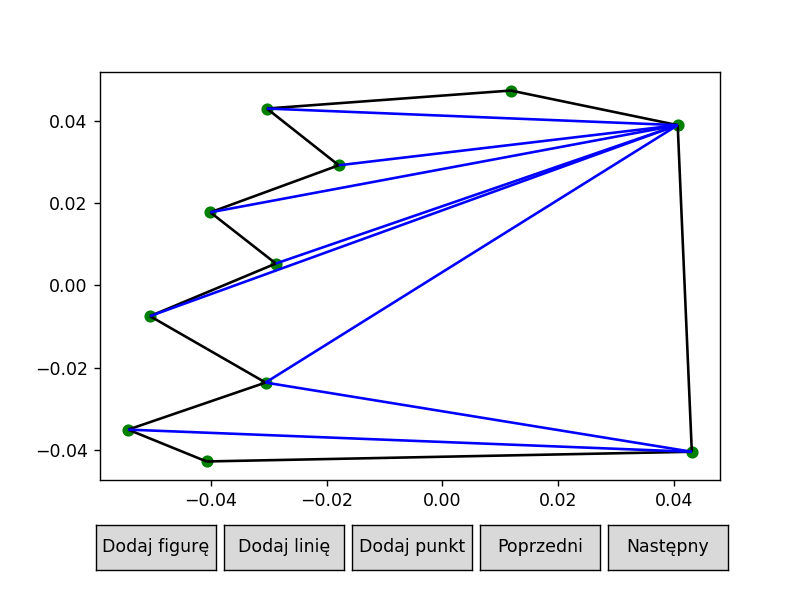

In [18]:
points11 = points_from_plot(plot14)
diagonals14, scenes14 = triangulation(points11)
plot14 = Plot(scenes14)
print(diagonals14)
plot14.draw()

<IPython.core.display.Javascript object>


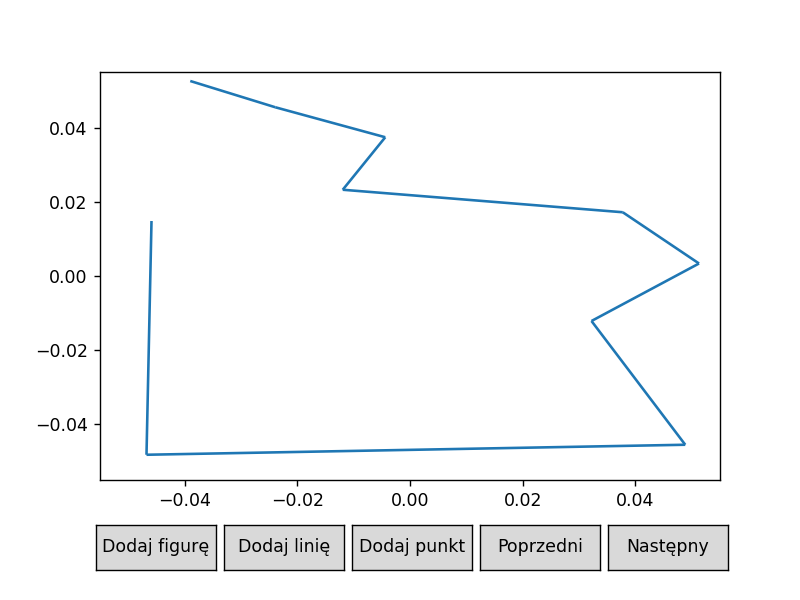

In [27]:
plot15 = Plot()
plot15.draw()

Polygon is y-monotonic.
[((-0.011931448905698722, 0.023253675442115943), (-0.023907255357311627, 0.045496322500939476)), ((-0.011931448905698722, 0.023253675442115943), (-0.03898790051860195, 0.05257352838329242)), ((-0.04586290051860195, 0.014828430344076729), (0.03774597044913999, 0.0171874989715277)), ((-0.04586290051860195, 0.014828430344076729), (-0.011931448905698722, 0.023253675442115943)), ((0.0512741962555916, 0.003370097010743381), (-0.04586290051860195, 0.014828430344076729)), ((0.032201615610430306, -0.012132353969648776), (-0.04586290051860195, 0.014828430344076729)), ((0.04883468012655935, -0.045496324557884084), (-0.04586290051860195, 0.014828430344076729))]


<IPython.core.display.Javascript object>


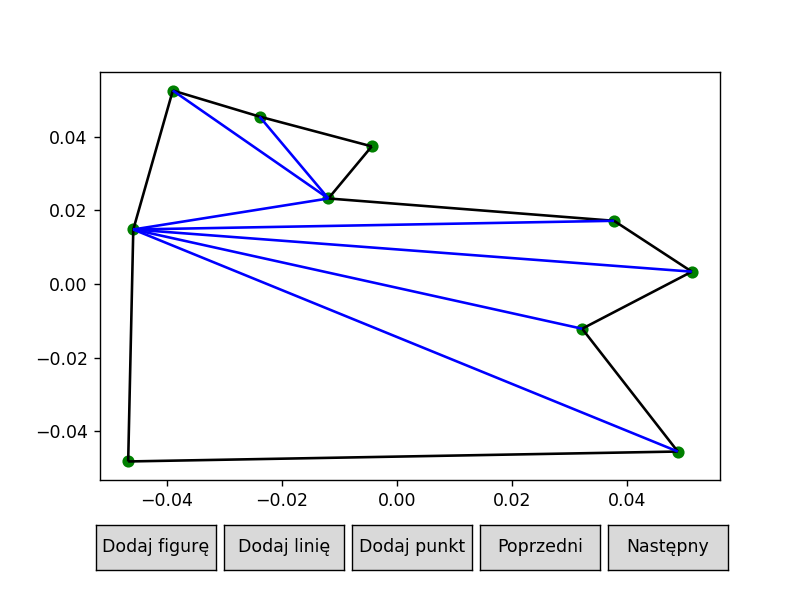

In [28]:
points12 = points_from_plot(plot15)
diagonals15, scenes15 = triangulation(points12)
plot15 = Plot(scenes15)
print(diagonals15)
plot15.draw()